In [33]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV 

# Add Grid Labels

In [ ]:
min_latitude = 48.3  
max_latitude = 60.0  
min_longitude = -139.05  
max_longitude = -114.03  


In [35]:
num_lat_cells = 5
num_lon_cells = 5

In [36]:
lat_step = (max_latitude - min_latitude) / num_lat_cells
lon_step = (max_longitude - min_longitude) / num_lon_cells

In [37]:
def get_grid_label(lat, lon, min_lat, max_lat, min_lon, max_lon, num_lat_cells, num_lon_cells):
    # Calculate the indices of the grid cell row and column
    lat_index = int((lat - min_lat) // lat_step)
    lon_index = int((lon - min_lon) // lon_step)
    
    # Adjust if the wildfire is exactly on the max boundary
    lat_index = min(lat_index, num_lat_cells - 1)
    lon_index = min(lon_index, num_lon_cells - 1)
    
    # Calculate the grid label
    grid_label = lat_index * num_lon_cells + lon_index + 1
    return grid_label

In [38]:
wildfire_df=pd.read_csv("merged_2012.csv")

In [39]:
wildfire_df['grid_label'] = wildfire_df.apply(
    lambda row: get_grid_label(
        row['latitude'],
        row['longitude'],
        min_latitude,
        max_latitude,
        min_longitude,
        max_longitude,
        num_lat_cells,
        num_lon_cells
    ), axis=1
)

In [40]:
wildfire_df

,Unnamed: 0,latitude,longitude,acq_date,confidence,geometry_fire,LATITUDE,LONGITUDE,DATE,PRCP,TMIN,TMAX,geometry_weather,distance,week_of_year,grid_label
0,0,58.728439,-117.236771,2012-01-22,h,POINT (-117.236771 58.728439),53.0667,-121.5167,2012-01-22,0.12,3.0,27.0,POINT (-121.5167 53.0667),7.097400,3,25
1,1,57.025085,-121.934845,2012-02-01,h,POINT (-121.934845 57.025085),53.0333,-122.5167,2012-02-01,0.08,21.0,38.0,POINT (-122.5167 53.0333),4.033969,5,19
2,2,53.131313,-115.990082,2012-02-04,h,POINT (-115.990082 53.131313),51.5833,-119.7833,2012-02-04,0.00,16.0,32.0,POINT (-119.7833 51.5833),4.096931,5,15
3,3,50.940090,-114.169312,2012-02-08,h,POINT (-114.169312 50.94009),51.5833,-119.7833,2012-02-08,0.00,9.0,30.0,POINT (-119.7833 51.5833),5.650715,6,10
4,4,58.049400,-114.157494,2012-02-12,h,POINT (-114.157494 58.0494),51.5833,-119.7833,2012-02-12,0.08,32.0,45.0,POINT (-119.7833 51.5833),8.570889,6,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158,3158,49.603424,-120.053345,2012-11-20,h,POINT (-120.053345 49.603424),49.7833,-119.7167,2012-11-20,0.19,43.0,47.0,POINT (-119.7167 49.7833),0.381687,47,4
3159,3159,51.392712,-122.958649,2012-11-23,h,POINT (-122.958649 51.392712),50.3000,-122.7333,2012-11-23,0.62,31.0,36.0,POINT (-122.7333 50.3),1.115707,47,9
3160,3160,52.061211,-122.916931,2012-12-04,h,POINT (-122.916931 52.061211),52.3833,-122.3667,2012-12-04,0.00,26.0,53.0,POINT (-122.3667 52.3833),0.637570,49,9
3161,3161,58.113380,-116.029503,2012-12-19,h,POINT (-116.029503 58.11338),53.0667,-121.5167,2012-12-19,0.41,-4.0,25.0,POINT (-121.5167 53.0667),7.455086,51,25


In [41]:
from sklearn.preprocessing import LabelEncoder

# XGBoost

In [ ]:

# Define X and y
X = wildfire_df[['week_of_year', 'TMIN', 'TMAX', 'PRCP']]
y = wildfire_df['grid_label']  # target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
y_encoded = label_encoder.fit_transform(y_train)

# Transform labels for test set as well
y_test_encoded = label_encoder.transform(y_test)

# Initialize XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit the classifier to the training set
model.fit(X_train, y_encoded)

# Predict the test set
y_pred_encoded = model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
scores = cross_val_score(model, X_train, y_encoded, cv=5)
print(f"Accuracy: {accuracy}")
print(f"Cross-validated scores: {scores}")
print(f"Average Score: {scores.mean()}")


# Make predictions using the model
input_data = pd.DataFrame({
    'week_of_year': [27],  # Example week
    'TMIN': [26],         # Example minimum temperature
    'TMAX': [53],         # Example maximum temperature
    'PRCP': [0]         # Example precipitation
})

predicted_grid_label = model.predict(input_data)
predicted_grid_label = label_encoder.inverse_transform(predicted_grid_label)
print(f"Predicted Grid Label: {predicted_grid_label}")


c:\Users\Dewang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.8704581358609794
Cross-validated scores: [0.85573123 0.84189723 0.85573123        nan        nan]
Average Score: nan
Predicted Grid Label: [25]


c:\Users\Dewang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Dewang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Dewang\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Dewang\AppData\Local\Programs\Python\Python311\Lib\site-packa

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           8       0.00      0.00      0.00         0
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         4
          13       1.00      0.80      0.89        15
          14       0.29      0.50      0.36         4
          15       1.00      1.00      1.00         1
          19       0.67      0.51      0.58        43
          20       1.00      0.12      0.22        16
          22       1.00      0.33      0.50         3
          23       0.83      0.67      0.74        15
          24       0.92      0.86      0.89       176
          25       0.87      0.97      0.92       341

    accuracy                           0.87       633
   macro avg       0.83      0.65      0.69       633
weighted avg       0.88      0.87      0.86       633



c:\Users\Dewang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dewang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dewang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

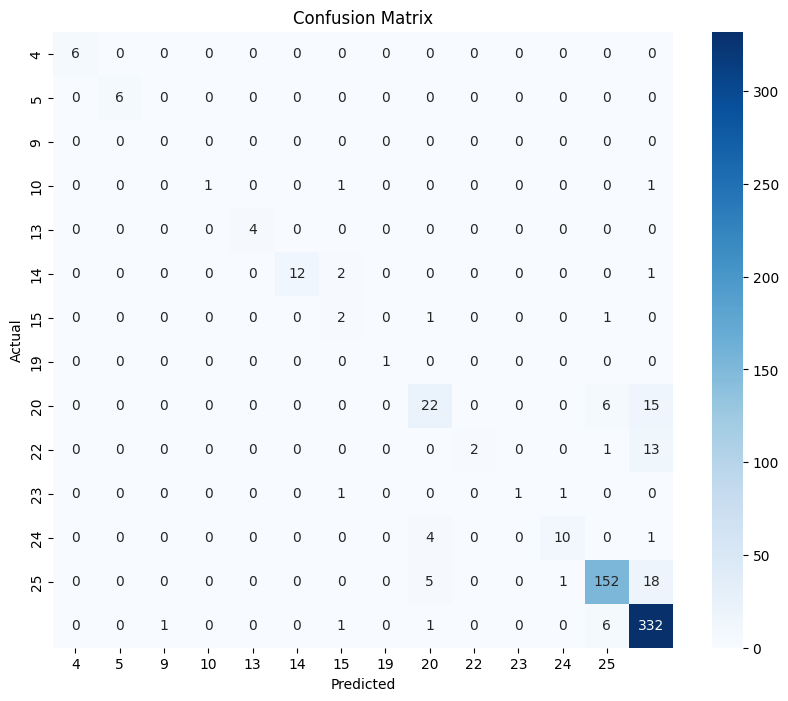

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)  

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  

In [ ]:
import numpy as np

mask = ~np.isnan(X_train).any(axis=1)
mask2 = ~np.isnan(X_test).any(axis=1)

# Apply mask to both X_train and y_encoded
X_train_clean = X_train[mask]
y_train_clean=y_train[mask]
y_encoded_clean = y_encoded[mask]

# Apply mask to both X_train and y_encoded
X_test_clean = X_test[mask2]
y_test_clean = y_test[mask2]

# Now X_train_clean and y_encoded_clean are aligned
rf_model.fit(X_train_clean, y_encoded_clean)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_encoded = rf_model.predict(X_test_clean)
y_pred = label_encoder.inverse_transform(y_pred_encoded) 

scores = cross_val_score(rf_model, X_train_clean, y_encoded_clean, cv=5)

# Evaluate the model
accuracy = accuracy_score(y_test_clean, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Cross-validated scores: {scores}")
print(f"Average Score: {scores.mean()}")


c:\Users\Dewang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.8698412698412699
Cross-validated scores: [0.85940594 0.83366337 0.85714286 0.84126984 0.86309524]
Average Score: 0.850915448687726


In [48]:
print(classification_report(y_test_clean, y_pred))

              precision    recall  f1-score   support

           4       1.00      0.50      0.67         6
           5       1.00      1.00      1.00         6
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         4
          13       1.00      0.93      0.97        15
          14       0.33      0.50      0.40         4
          15       1.00      1.00      1.00         1
          19       0.69      0.47      0.56        43
          20       1.00      0.19      0.32        16
          22       1.00      0.33      0.50         3
          23       0.78      0.58      0.67        12
          24       0.89      0.87      0.88       176
          25       0.87      0.98      0.92       341

    accuracy                           0.87       630
   macro avg       0.89      0.67      0.72       630
weighted avg       0.87      0.87      0.86       630



In [49]:
input_data = pd.DataFrame({
    'week_of_year': [27],  # Example week
    'TMIN': [14],         # Example minimum temperature
    'TMAX': [25],         # Example maximum temperature
    'PRCP': [0]         # Example precipitation
})

predicted_grid_label = rf_model.predict(input_data)
predicted_grid_label = label_encoder.inverse_transform(predicted_grid_label)
print(f"Predicted Grid Label: {predicted_grid_label}")

Predicted Grid Label: [25]


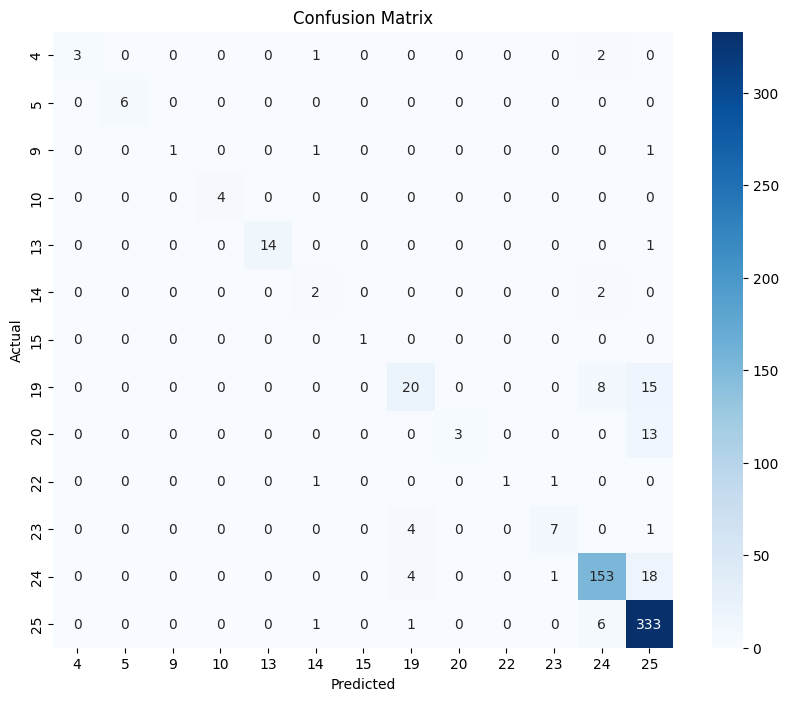

In [50]:
cm = confusion_matrix(y_test_clean, y_pred)
labels = np.unique(y_test)  

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# MLP

In [51]:
# Initialize MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 96, 178), max_iter=500, activation='relu', solver='adam', random_state=42)

# Train the model
mlp.fit(X_train_clean, y_train_clean)

# Predict and evaluate the model
y_pred = mlp.predict(X_test_clean)
scores = cross_val_score(mlp, X_train_clean, y_encoded_clean, cv=5)
print(f"Accuracy: {accuracy_score(y_test_clean, y_pred)}")
print(f"Cross-validated scores: {scores}")
print(f"Average Score: {scores.mean()}")



c:\Users\Dewang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.8222222222222222
Cross-validated scores: [0.77425743 0.77425743 0.75       0.74801587 0.75      ]
Average Score: 0.7593061449002043


In [52]:
print(classification_report(y_test_clean, y_pred))

              precision    recall  f1-score   support

           4       1.00      0.83      0.91         6
           5       0.86      1.00      0.92         6
           9       1.00      0.33      0.50         3
          10       0.00      0.00      0.00         4
          13       0.93      0.93      0.93        15
          14       0.67      0.50      0.57         4
          15       1.00      1.00      1.00         1
          19       0.54      0.44      0.49        43
          20       1.00      0.06      0.12        16
          22       1.00      0.33      0.50         3
          23       0.67      0.50      0.57        12
          24       0.80      0.84      0.82       176
          25       0.86      0.92      0.89       341

    accuracy                           0.82       630
   macro avg       0.79      0.59      0.63       630
weighted avg       0.82      0.82      0.81       630



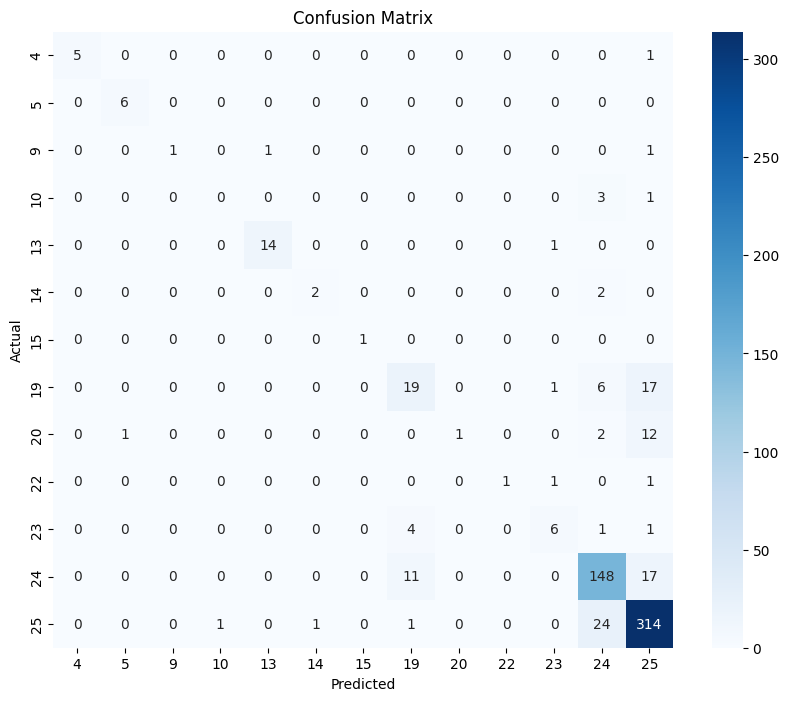

In [53]:
cm = confusion_matrix(y_test_clean, y_pred)
labels = np.unique(y_test)  

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()